# Deep Learning Model

> In this module, we prepare different deep learning models for tabular data

In [315]:
#| default_exp dl

In [316]:
!pip install -Uqq fastai

In [317]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
#| export
from fastbook import *
import xgboost as xgb
from scipy.stats import spearmanr,pearsonr
from katlas.core import Data
from katlas.feature import *
from sklearn.model_selection import train_test_split, StratifiedGroupKFold

### Dataset

In [319]:
#| export
class GeneralDataset:
    def __init__(self, df, feature_cols, target_cols=None):
        
        self.test = False if target_cols is not None else True
        
        self.X = df[feature_cols].values 
        self.y = df[target_cols].values if not self.test else None
        
        self.len = df.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        X = torch.Tensor(self.X[index])
        if self.test:
            return X
        else:
            y = torch.Tensor(self.y[index])
            return X, y

## Model

In [320]:
#| export
def MLP1(in_channel, out_channel,dp = 0.2):
    model = nn.Sequential(
        nn.Linear(in_channel, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(dp),
        nn.PReLU(),
        nn.Linear(512, 218),
        nn.BatchNorm1d(218),
        nn.Dropout(dp),
        nn.PReLU(),
        nn.Linear(218, out_channel)
    )
    return model

## Trainer

In [391]:
#| export
def dl_trainer(df, # dataframe contains features and targets
               splits, # tuple (train_index, valid_index)
               feat_col, # ['feat1', 'feat2', ...]
               target_col, # ['target1']
               model, # pytorch model
               loss, # loss function
               save, # string, it will save to models/name.pth
               epochs=4, # epochs to train
              ):
    
    train = df.loc[splits[0]]
    valid = df.loc[splits[1]]
    
    train_ds = GeneralDataset(train, feat_col, target_col)
    valid_ds = GeneralDataset(valid, feat_col, target_col)

    dls = DataLoaders.from_dsets(train_ds, valid_ds, num_workers=4)
    
    learn = Learner(dls.cuda(), model.cuda(), loss)
    
    lr_max = learn.lr_find()
    plt.show()
    plt.close()
    print(lr_max)
    
    # cbs = [
    #    SaveModelCallback(with_opt=True), # optimizer=True, can also set monitor
    #    EarlyStoppingCallback(patience=3), # monitor
    #   ]
    
    learn.fit_one_cycle(epochs, lr_max) # cbs= cbs
    
    if save is not None:
        learn.save(save)
    
    return learn

In [384]:
#| export
def dl_predict(df, feat_col, model, checkpoint_pth):
    test_dset = GeneralDataset(df,feat_col)
    test_dl = torch.utils.data.DataLoader(test_dset)
    
    learn = Learner(None, model.cuda(), loss_func=1)
    learn.load(checkpoint_pth)
    
    learn.model.eval()
    
    preds = []
    for data in test_dl:
        inputs = data.cuda()
        outputs = learn.model(inputs) #learn.model(x).sigmoid().detach().cpu().numpy()

        preds.append(outputs.detach().cpu().numpy())

    preds = np.concatenate(preds)
    
    pred_df = df.copy()
    pred_df['pred'] = preds
    
    return pred_df

## Example

In [392]:
df = Data.get_prepared_data()

In [393]:
feat_col = ['position'] + df.columns.tolist()[5:]

In [394]:
target_col = ['target'] # need to be a list of strings

In [395]:
kinase = Data.get_kinase_info_full()

info = df[['kinase']].merge(kinase,'left')

(info.kinase == df.kinase).value_counts()

True    59004
Name: kinase, dtype: int64

In [396]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=123)

for fold, (train_idx, test_idx) in enumerate(sgkf.split(info.index.values, info.category,info.kinase)):
    print(f'# kinase in test set: {info.loc[test_idx].kinase.unique().shape[0]}')
    print(f'# kinase in train set: {info.loc[train_idx].kinase.unique().shape[0]}')
    print(f'test set: {info.loc[test_idx].kinase.unique()}')
    break

# kinase in test set: 61
# kinase in train set: 237
test set: ['ACVR2B' 'AKT1' 'ALPHAK3' 'AMPKA1' 'AURA' 'BMPR1B' 'CAMK1B' 'CAMKK2' 'CAMLCK' 'CDK4' 'CDK6' 'CDK8' 'CDK13' 'CHK1' 'CK1D' 'CK1G2' 'DMPK1' 'DSTYK' 'DYRK1A' 'ERK5' 'GRK2' 'GRK4' 'GRK7' 'HIPK1' 'ICK'
 'IRAK1' 'KHS1' 'LOK' 'MAPKAPK5' 'MARK2' 'MARK4' 'MEKK2' 'MLK3' 'MNK1' 'MSK2' 'NDR1' 'NDR2' 'NEK2' 'NEK9' 'P70S6K' 'PAK2' 'PAK3' 'PBK' 'PKCA' 'PKCE' 'PKCZ' 'PKG1' 'PLK2' 'PLK3' 'RIPK2' 'RIPK3' 'RSK4'
 'SBK' 'SIK' 'SKMLCK' 'SRPK3' 'SSTK' 'TNIK' 'VRK2' 'YANK2' 'ZAK']


In [397]:
splits = (train_idx,test_idx)

In [398]:
loss = nn.MSELoss()

model = MLP1(len(feat_col), 1, dp=0.1)

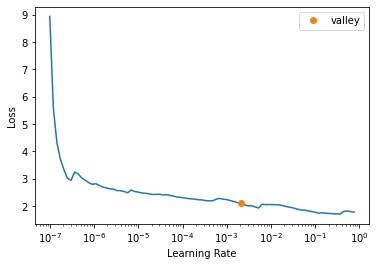

SuggestedLRs(valley=0.0020892962347716093)


epoch,train_loss,valid_loss,time
0,1.328314,1.163631,00:04
1,0.833455,1.130782,00:04
2,0.730989,1.056983,00:05
3,0.776099,0.990840,00:05
4,0.955984,0.971958,00:05
5,0.794455,0.968055,00:05
6,0.938699,0.870307,00:04
7,0.688655,0.915095,00:04
8,0.649584,0.914397,00:05
9,1.108164,0.816926,00:04


In [399]:
learn = dl_trainer(df, splits, feat_col, target_col, model, loss, save = 'temp', epochs=20)

In [400]:
out = dl_predict(valid, feat_col, model, checkpoint_pth = 'temp')

In [401]:
out[['target','pred']].corr()

,target,pred
target,1.000000,0.643832
pred,0.643832,1.000000


In [402]:
out[['target','pred']].corr('spearman')

,target,pred
target,1.000000,0.583553
pred,0.583553,1.000000


In [403]:
#| hide
import nbdev; nbdev.nbdev_export()